In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, dates

In [167]:
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

In [203]:
gmx_arb = pd.read_csv('data/GMX_Arbitrum_Fees_2021-08-31_2022-07-05.csv')
gmx_avax = pd.read_csv('data/GMX_Avax_Fees_2022-01-06_2022-07-05.csv')
gmx_price_raw = pd.read_csv('data/gmx-usd-price.csv')
gmx_arb_staked = pd.read_csv('data/gmx_staked_arbi.csv')
gmx_avax_staked = pd.read_csv('data/gmx_staked_avax.csv')
gmx_arb.head()

,Date,Swap,Margin trading,Mint GLP,Burn GLP,Liquidation,Cumulative
0,2021-08-31,0.399321,0.153256,0.118304,0.206160,0.0,0.877041
1,2021-09-01,866.365339,101.848845,4843.226667,0.033713,0.0,5812.351605
2,2021-09-02,854.002762,741.708859,1610.527787,134.264965,0.0,9152.855978
3,2021-09-03,1388.241363,3127.266851,22.380404,0.000000,0.0,13690.744595
4,2021-09-04,219.024733,768.756821,82.883759,0.000000,0.0,14761.409908


<AxesSubplot:title={'center':'Weekly GMX Revenue Avax'}, xlabel='Week', ylabel='Revenue'>

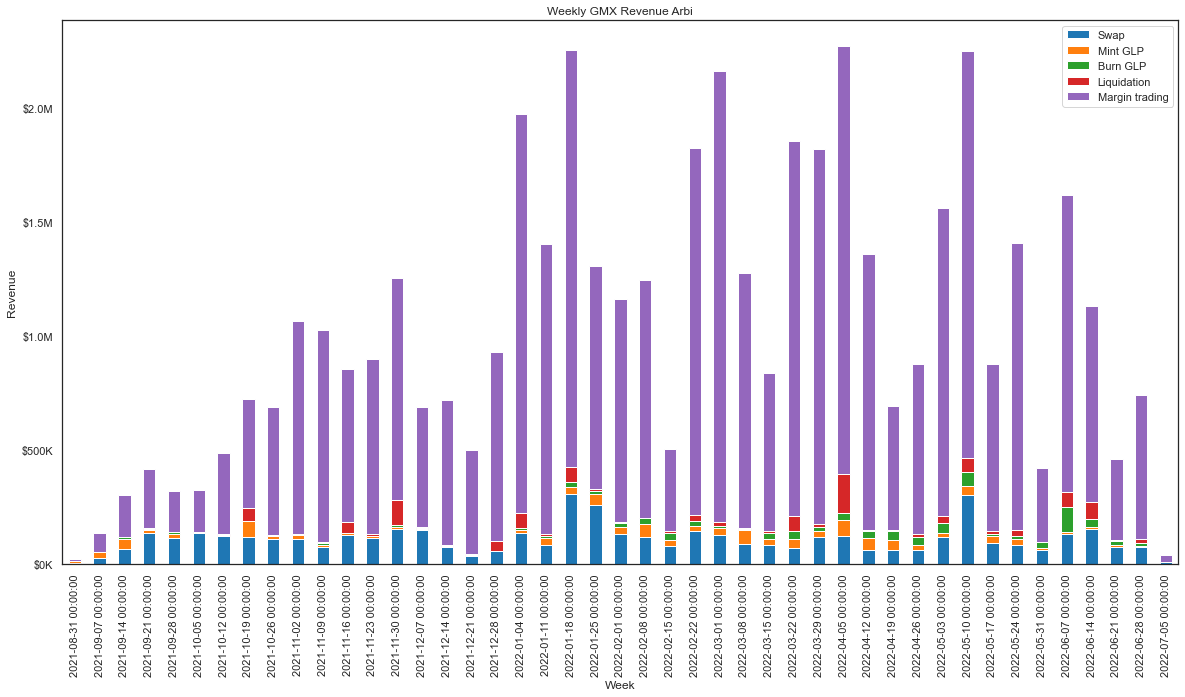

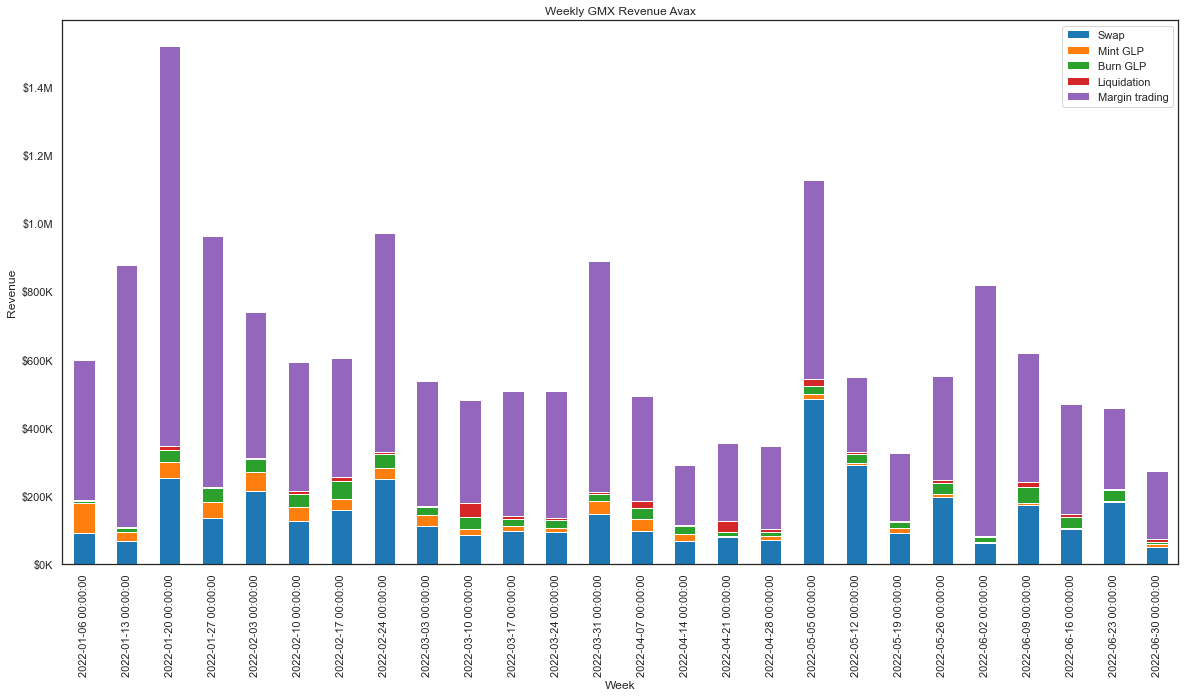

In [169]:
plt.rcParams["figure.figsize"] = [20, 10]
sns.set_theme(style="white", palette=None)

def weekly_chain_rev(chain, gmx_data):
    gmx_data.index = pd.to_datetime(gmx_data['Date'])
    gmx_data_res = gmx_data.resample('7D').sum()

    cum_fee = gmx_data_res[['Swap',  'Mint GLP', 'Burn GLP', 'Liquidation','Margin trading']].plot(kind='bar', stacked=True)
    cum_fee.set( 
           xlabel='Week', 
           ylabel='Revenue',
           title=f'Weekly GMX Revenue {chain}')
    cum_fee.yaxis.set_major_formatter(currency)
    # cum_fee_arb.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
    return cum_fee

weekly_chain_rev('Arbi', gmx_arb)
weekly_chain_rev('Avax', gmx_avax)

<AxesSubplot:>

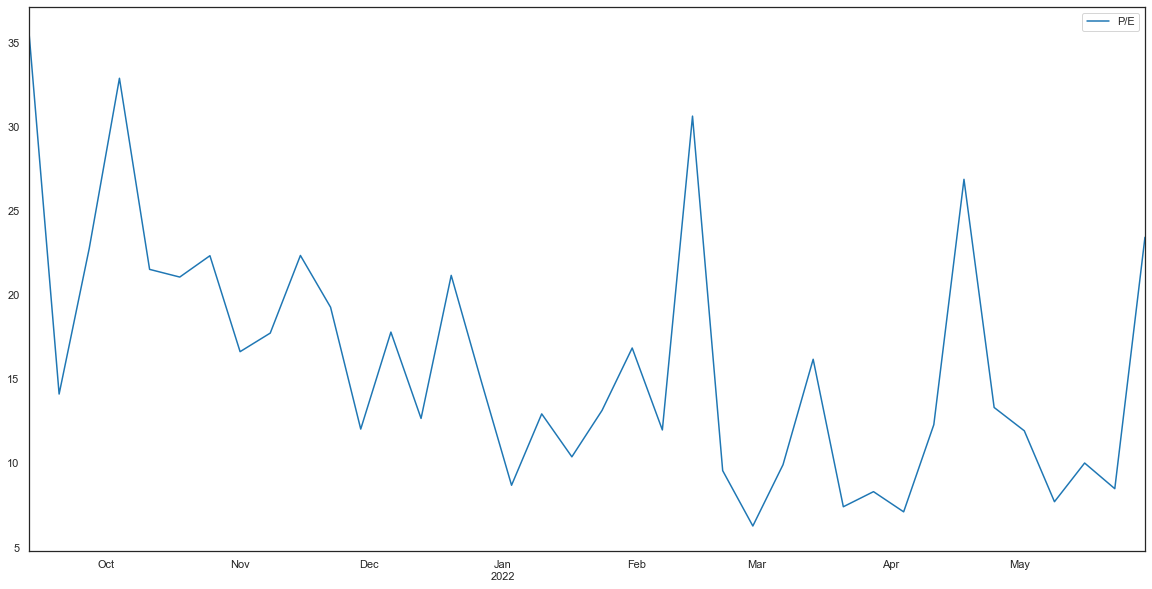

In [233]:
gmx_price_raw.index = pd.to_datetime(gmx_price_raw['Date'])
gmx_price_raw.index = gmx_price_raw.index.tz_localize(None)
gmx_price = gmx_price_raw.drop(['Date'], axis=1)

def gmx_yield(gmx_data, chain_staked_table):
    gmx_total_fee = pd.DataFrame(gmx_data.set_index('Date').drop(['Cumulative'], axis=1).sum(axis=1)*0.3)
    gmx_total_fee.columns = ['GMX_fee']
    
    chain_staked_table['time'] = pd.to_datetime(gmx_arb_staked['time'], unit='s')
    chain_staked_table = chain_staked_table.sort_values(by=['time']).set_index('time').resample('1D').mean().dropna()

    master_df = pd.merge(gmx_price, gmx_total_fee, left_index=True, right_index=True)
    master_df = pd.merge(chain_staked_table[['balance']], master_df, left_index=True, right_index=True)
    
    master_df['usd_balance'] = master_df.balance*master_df.price
    master_df['yield'] = master_df.GMX_fee/master_df.usd_balance
    master_df['ARR'] = (((1 + master_df['yield'])**365)-1)
    master_df['P/E'] = master_df.usd_balance/(master_df.usd_balance*master_df.ARR)
    
    pe_table_week = master_df[['P/E']].resample('7D').mean()

    return pe_table_week


gmx_yield(gmx_arb, gmx_arb_staked).plot()

In [189]:
gmx_arb_staked = pd.read_csv('data/gmx_staked_arbi.csv')
gmx_avax_staked = pd.read_csv('data/gmx_staked_avax.csv')

gmx_arb_staked['time'] = pd.to_datetime(gmx_arb_staked['time'], unit='s')
gmx_arb_staked = gmx_arb_staked.sort_values(by=['time']).set_index('time')
gmx_arb_staked.resample('1D').mean().dropna().head(50)

,balance,block
time,,
2021-07-22,5.227741e+06,148702.0
2021-07-27,5.221858e+06,169945.0
2021-07-31,5.272860e+06,191188.0
2021-08-05,5.279360e+06,212431.0
2021-09-01,5.431750e+06,233674.0
2021-09-02,5.431750e+06,254917.0
2021-09-04,5.431750e+06,276160.0
2021-09-06,5.584708e+06,297403.0
2021-09-08,5.603091e+06,318646.0
